In [1]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
nusc = NuScenes(version='v1.0-mini', dataroot='/Users/tiffanydarini/nuscenes-devkit/python-sdk/tutorials/data/sets/nuscenes/v1.0-mini', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.332 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


### Fonction utiles et imports nécessaires

In [2]:
# Fonction qui renvoie les tables ego_pose d'une scène donnée
def get_poses(scene_token):
    pose_list = []
    scene_rec = nusc.get('scene', scene_token)
    sample_rec = nusc.get('sample', scene_rec['first_sample_token'])
    sd_rec = nusc.get('sample_data', sample_rec['data']['LIDAR_TOP'])
    
    ego_pose = nusc.get('ego_pose', sd_rec['token'])
    pose_list.append(ego_pose)

    while sd_rec['next'] != '':
        sd_rec = nusc.get('sample_data', sd_rec['next'])
        ego_pose = nusc.get('ego_pose', sd_rec['token'])
        pose_list.append(ego_pose)

    return pose_list

In [3]:
# On crée une fonction qui renvoie la liste des rangs dans les listes X,Y des objets immobiles de 
# cette liste et donc d'une même catégorie, ainsi que la liste des objets mobiles 
from math import sqrt

def immobile(X,Y):
    Immo = []
    Mobile = []
    n = len(X) # Nombre d'élément dans la catégorie 
    for i in range(0,n-1):
        X_coord = X[i]
        Y_coord = Y[i]
        if len(X_coord)==1 :
            Immo.append(i)
        else : 
            d = 0 
            for k in range(0,len(X_coord)-1):
                d+= sqrt((X_coord[k+1]-X_coord[k])**2+(Y_coord[k+1]-Y_coord[k])**2)
            if d<2 : # Si la distance totale parcourue par l'objet est inférieur à 2m, on considère que l'objet bouge pas
                Immo.append(i)
            else :
                Mobile.append(i)
    return Immo,Mobile  

In [4]:
from dtw import *
import matplotlib.pyplot as plt
from datetime import timedelta

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [5]:
import numpy as np 
from math import sqrt 

# Fonction qui renvoie la matrice des distances 
def Matrice_distance(X_ego,Y_ego,X_veh,Y_veh):
    M = np.zeros((len(X_veh),len(X_ego)))
    for i in range(0,len(X_veh)):
        for j in range(0,len(X_ego)):
            #M[i,j] = sqrt((X_veh[len(X_veh)-1-i]-X_ego[j])**2+(Y_veh[len(Y_veh)-1-i]-Y_ego[j])**2)
            M[i,j] = sqrt((X_veh[i]-X_ego[j])**2+(Y_veh[i]-Y_ego[j])**2)
    return M 
     

In [6]:
import numpy as np 
from math import sqrt 

# Fonction qui renvoie la matrice des distances entre 
# les pts qui interagissent dans le temps 

def M_distance_time(X_ego,Y_ego,T_ego,X_veh,Y_veh,T_veh):
    
    debut = max(T_ego[0],T_veh[0]) # Temps début detection vehicule 1 
    fin = min(T_ego[len(T_ego)-1],T_veh[len(T_veh)-1]) # Temps fin detection vehicule 1 

    # On va créer la liste des indices des élements du veh 1 qui sont en même temps que le veh 2
    L_indice_ego = []
    for k in range(0,len(T_ego)):
        if debut<=T_ego[k]<=fin:
            L_indice_ego.append(k)
            
    # Pareil pour le veh 
    L_indice_veh = []
    for k in range(0,len(T_veh)):
        if debut<=T_veh[k]<=fin:
            L_indice_veh.append(k)
    
    M = np.zeros((len(L_indice_veh),len(L_indice_ego)))
    for i in range(0,len(L_indice_veh)):
        for j in range(0,len(L_indice_ego)):
            M[i,j] = sqrt((X_veh[L_indice_veh[i]]-X_ego[L_indice_ego[j]])**2+(Y_veh[L_indice_veh[i]]-Y_ego[L_indice_ego[j]])**2)
    
    return M 

### Résultats de DTW 

In [7]:
# On utilise ce qu'on a déjà (liste ego_poses)
scene_name = 'scene-0061'
scene_token = nusc.field2token('scene','name',scene_name)[0]
Liste_ego_poses = get_poses(scene_token) 

# Création des liste de coordonnées du véhicule égo 
X_coord =[]
Y_coord =[]
Z_coord =[]
T_timestamp = [] # liste des timestamps
for k in range(0,len(Liste_ego_poses)):
    X_coord.append(Liste_ego_poses[k]['translation'][0])
    Y_coord.append(Liste_ego_poses[k]['translation'][1])
    Z_coord.append(Liste_ego_poses[k]['translation'][2])
    T_timestamp.append(Liste_ego_poses[k]['timestamp'])

# Ensemble des token des échantillons de la scene 
sample_token = nusc.field2token('sample','scene_token',scene_token)

# Ensemble des sample_annotation de la scène :

sample_annotation_token = []
for k in sample_token : 
    L = nusc.field2token('sample_annotation','sample_token',k)
    sample_annotation_token = sample_annotation_token + L
    
# On créé la liste des token des instances présents dans les sample_annotation
L_instance_token = []
for k in sample_annotation_token :
    exemple = nusc.get('sample_annotation', k)
    L_instance_token.append(exemple['instance_token'])
# Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
L_instance_token = list(set(L_instance_token))

# Liste des catégories d'objet dans la scène 
L_category_name = []
for k in sample_annotation_token :
    exemple = nusc.get('sample_annotation', k)
    L_category_name.append(exemple['category_name'])
L_category_name = list(set(L_category_name))
L_category_name

['movable_object.pushable_pullable',
 'vehicle.motorcycle',
 'vehicle.bicycle',
 'vehicle.bus.rigid',
 'movable_object.trafficcone',
 'vehicle.car',
 'human.pedestrian.adult',
 'vehicle.construction',
 'human.pedestrian.construction_worker',
 'movable_object.debris',
 'movable_object.barrier',
 'vehicle.truck']

#### Travail sur les voitures

In [8]:
# On travail sur les voitures
catego_name = 'vehicle.car'
catego_token = nusc.field2token('category','name',catego_name)
category = nusc.get('category',catego_token[0])
category

{'token': 'fd69059b62a3469fbaef25340c0eab7f',
 'name': 'vehicle.car',
 'description': 'Vehicle designed primarily for personal use, e.g. sedans, hatch-backs, wagons, vans, mini-vans, SUVs and jeeps. If the vehicle is designed to carry more than 10 people use vehicle.bus. If it is primarily designed to haul cargo use vehicle.truck. '}

In [9]:
# Ensemble des instances appartenant à la fois à la scène et à la catégorie
L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 

L=[]
for k in L_instance_category : 
    instance_category = nusc.get('instance',k)
    nbr_annotations = instance_category['nbr_annotations']
    if nbr_annotations == 1:
        L.append([instance_category['first_annotation_token']])
    else : 
        H = []
        first_token = instance_category['first_annotation_token']
        last_token = instance_category['last_annotation_token']
        current_token = first_token 
        
        i = 0 
        while i!= nbr_annotations :
            current_ann = nusc.get('sample_annotation', current_token)
            H.append(current_ann['token'])
            current_token = current_ann['next'] #On passe au suivant
            i+=1
        L.append(H)
# Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
# les token des sample_annotation pour un élément de cette catégorie. 

# Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
# on va pouvoir récupérer leurs positions 

X = []
Y = []
Z = []
T_time = []
for k in L :
    x = []
    y = []
    z = []
    t = []
    for j in k :
        sample_annotation = nusc.get('sample_annotation',j)
        x.append(sample_annotation['translation'][0])
        y.append(sample_annotation['translation'][1])
        z.append(sample_annotation['translation'][2])
        t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
    X.append(x)
    Y.append(y)
    Z.append(z)
    T_time.append(t)

Immo, Mobile = immobile(X,Y)

# On conserve uniquement les objets mobiles 
X_mobile=[X[i] for i in Mobile]
Y_mobile=[Y[i] for i in Mobile]
Z_mobile=[Z[i] for i in Mobile]
T_mobile = [T_time[i] for i in Mobile]
len(X_mobile)

5

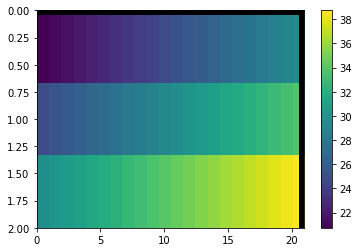

In [10]:
# Vehicule 1
i = 0 
M_distance = M_distance_time(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
alignment = dtw(M_distance)
ax = plt.imshow(M_distance,aspect='auto',interpolation='none', extent=[0,max(alignment.index2),max(alignment.index1),0])
plt.colorbar()
plt.plot([alignment.index2[k] for k in range(0,len(alignment.index2))],[alignment.index1[k] for k in range(0,len(alignment.index1))],'black',linewidth=10)

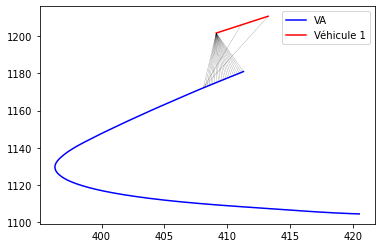

In [11]:
Chemin = [[alignment.index1[k],alignment.index2[k]] for k in range(0,len(alignment.index1))]

plt.plot(X_coord,Y_coord,'b',label='VA')
plt.plot([X_mobile[i][k] for k in range(0,len(X_mobile[i]))],[Y_mobile[i][k] for k in range(0,len(Y_mobile[i]))],'r',label = 'Véhicule '+str(i+1))
for k in range(0,len(Chemin)):
    trait_x_coord =[X_mobile[i][Chemin[k][0]],X_coord[Chemin[k][1]]]
    trait_y_coord =[Y_mobile[i][Chemin[k][0]],Y_coord[Chemin[k][1]]]
    plt.plot(trait_x_coord,trait_y_coord,'black',linestyle='--',linewidth=0.2)
plt.legend()

Text(0, 0.5, 'Point de la trajectoire du vehicule.car2')

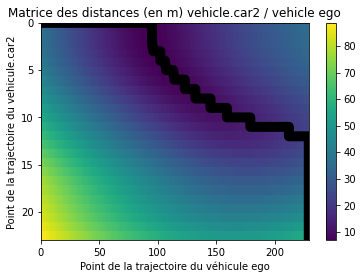

In [12]:
# Vehicule 2
i = 1
M_distance = M_distance_time(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
alignment = dtw(M_distance)
ax = plt.imshow(M_distance,aspect='auto',interpolation='none', extent=[0,max(alignment.index2),max(alignment.index1),0])
plt.colorbar()
plt.plot([alignment.index2[k] for k in range(0,len(alignment.index2))],[alignment.index1[k] for k in range(0,len(alignment.index1))],'black',linewidth=10)
plt.title ('Matrice des distances (en m) vehicle.car2 / vehicle ego')
plt.xlabel('Point de la trajectoire du véhicule ego')
plt.ylabel('Point de la trajectoire du vehicule.car2')

Text(0.5, 1.0, 'Alignement optimal des trajectoires vehicle.car2 / vehicle ego')

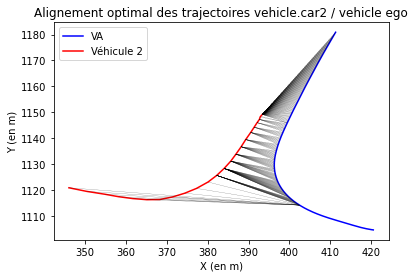

In [13]:
Chemin = [[alignment.index1[k],alignment.index2[k]] for k in range(0,len(alignment.index1))]

plt.plot(X_coord,Y_coord,'b',label='VA')
plt.plot([X_mobile[i][k] for k in range(0,len(X_mobile[i]))],[Y_mobile[i][k] for k in range(0,len(Y_mobile[i]))],'r',label = 'Véhicule '+str(i+1))
for k in range(0,len(Chemin)):
    trait_x_coord =[X_mobile[i][Chemin[k][0]],X_coord[Chemin[k][1]]]
    trait_y_coord =[Y_mobile[i][Chemin[k][0]],Y_coord[Chemin[k][1]]]
    plt.plot(trait_x_coord,trait_y_coord,'black',linestyle='--',linewidth=0.2)
plt.legend()
plt.xlabel('X (en m)')
plt.ylabel('Y (en m)')
plt.title('Alignement optimal des trajectoires vehicle.car2 / vehicle ego')

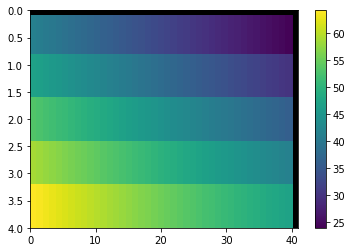

In [14]:
# Vehicule 3
i = 2
M_distance = M_distance_time(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
alignment = dtw(M_distance)
ax = plt.imshow(M_distance,aspect='auto',interpolation='none', extent=[0,max(alignment.index2),max(alignment.index1),0])
plt.colorbar()
plt.plot([alignment.index2[k] for k in range(0,len(alignment.index2))],[alignment.index1[k] for k in range(0,len(alignment.index1))],'black',linewidth=10)

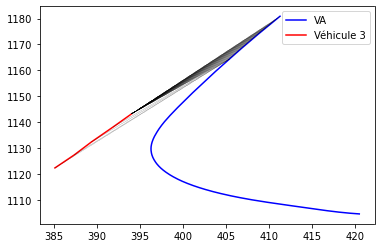

In [15]:
Chemin = [[alignment.index1[k],alignment.index2[k]] for k in range(0,len(alignment.index1))]

plt.plot(X_coord,Y_coord,'b',label='VA')
plt.plot([X_mobile[i][k] for k in range(0,len(X_mobile[i]))],[Y_mobile[i][k] for k in range(0,len(Y_mobile[i]))],'r',label = 'Véhicule '+str(i+1))
for k in range(0,len(Chemin)):
    trait_x_coord =[X_mobile[i][Chemin[k][0]],X_coord[Chemin[k][1]]]
    trait_y_coord =[Y_mobile[i][Chemin[k][0]],Y_coord[Chemin[k][1]]]
    plt.plot(trait_x_coord,trait_y_coord,'black',linestyle='--',linewidth=0.2)
plt.legend()

Text(0, 0.5, 'Point de la trajectoire du vehicule.car2')

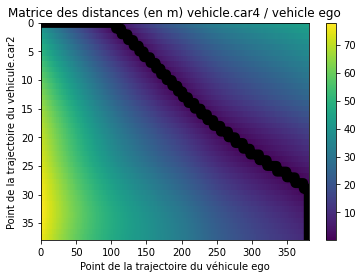

In [16]:
# Vehicule 4
i = 3
M_distance = M_distance_time(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
alignment = dtw(M_distance)
ax = plt.imshow(M_distance,aspect='auto',interpolation='none', extent=[0,max(alignment.index2),max(alignment.index1),0])
plt.colorbar()
plt.plot([alignment.index2[k] for k in range(0,len(alignment.index2))],[alignment.index1[k] for k in range(0,len(alignment.index1))],'black',linewidth=10)
plt.title ('Matrice des distances (en m) vehicle.car4 / vehicle ego')
plt.xlabel('Point de la trajectoire du véhicule ego')
plt.ylabel('Point de la trajectoire du vehicule.car2')

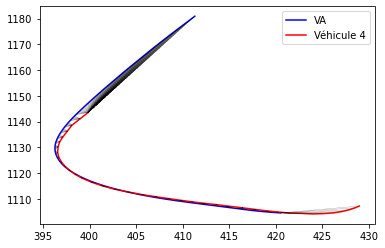

In [17]:
Chemin = [[alignment.index1[k],alignment.index2[k]] for k in range(0,len(alignment.index1))]

plt.plot(X_coord,Y_coord,'b',label='VA')
plt.plot([X_mobile[i][k] for k in range(0,len(X_mobile[i]))],[Y_mobile[i][k] for k in range(0,len(Y_mobile[i]))],'r',label = 'Véhicule '+str(i+1))
for k in range(0,len(Chemin)):
    trait_x_coord =[X_mobile[i][Chemin[k][0]],X_coord[Chemin[k][1]]]
    trait_y_coord =[Y_mobile[i][Chemin[k][0]],Y_coord[Chemin[k][1]]]
    plt.plot(trait_x_coord,trait_y_coord,'black',linestyle='--',linewidth=0.2)
plt.legend()

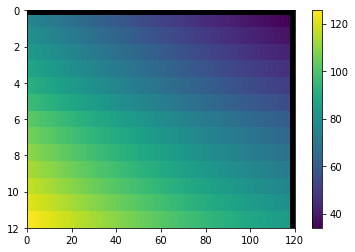

In [18]:
# Vehicule 5
i = 4
M_distance = M_distance_time(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
alignment = dtw(M_distance)
ax = plt.imshow(M_distance,aspect='auto',interpolation='none', extent=[0,max(alignment.index2),max(alignment.index1),0])
plt.colorbar()
plt.plot([alignment.index2[k] for k in range(0,len(alignment.index2))],[alignment.index1[k] for k in range(0,len(alignment.index1))],'black',linewidth=10)

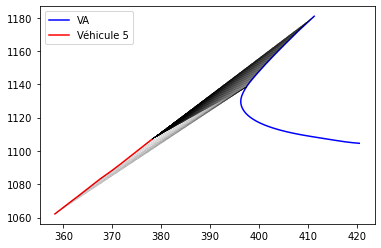

In [19]:
Chemin = [[alignment.index1[k],alignment.index2[k]] for k in range(0,len(alignment.index1))]

plt.plot(X_coord,Y_coord,'b',label='VA')
plt.plot([X_mobile[i][k] for k in range(0,len(X_mobile[i]))],[Y_mobile[i][k] for k in range(0,len(Y_mobile[i]))],'r',label = 'Véhicule '+str(i+1))
for k in range(0,len(Chemin)):
    trait_x_coord =[X_mobile[i][Chemin[k][0]],X_coord[Chemin[k][1]]]
    trait_y_coord =[Y_mobile[i][Chemin[k][0]],Y_coord[Chemin[k][1]]]
    plt.plot(trait_x_coord,trait_y_coord,'black',linestyle='--',linewidth=0.2)
plt.legend()

#### Travail sur les bus

In [20]:
# On travail sur les bus
catego_name = 'vehicle.bus.rigid'
catego_token = nusc.field2token('category','name',catego_name)
category = nusc.get('category',catego_token[0])
category

{'token': 'fedb11688db84088883945752e480c2c',
 'name': 'vehicle.bus.rigid',
 'description': 'Rigid bus subcategory.'}

In [21]:
# Ensemble des instances appartenant à la fois à la scène et à la catégorie
L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 

L=[]
for k in L_instance_category : 
    instance_category = nusc.get('instance',k)
    nbr_annotations = instance_category['nbr_annotations']
    if nbr_annotations == 1:
        L.append([instance_category['first_annotation_token']])
    else : 
        H = []
        first_token = instance_category['first_annotation_token']
        last_token = instance_category['last_annotation_token']
        current_token = first_token 
        
        i = 0 
        while i!= nbr_annotations :
            current_ann = nusc.get('sample_annotation', current_token)
            H.append(current_ann['token'])
            current_token = current_ann['next'] #On passe au suivant
            i+=1
        L.append(H)
# Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
# les token des sample_annotation pour un élément de cette catégorie. 

# Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
# on va pouvoir récupérer leurs positions 

X = []
Y = []
Z = []
T_time = []
for k in L :
    x = []
    y = []
    z = []
    t = []
    for j in k :
        sample_annotation = nusc.get('sample_annotation',j)
        x.append(sample_annotation['translation'][0])
        y.append(sample_annotation['translation'][1])
        z.append(sample_annotation['translation'][2])
        t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
    X.append(x)
    Y.append(y)
    Z.append(z)
    T_time.append(t)

Immo, Mobile = immobile(X,Y)

# On conserve uniquement les objets mobiles 
X_mobile=[X[i] for i in Mobile]
Y_mobile=[Y[i] for i in Mobile]
Z_mobile=[Z[i] for i in Mobile]
T_mobile = [T_time[i] for i in Mobile]
len(X_mobile)

1

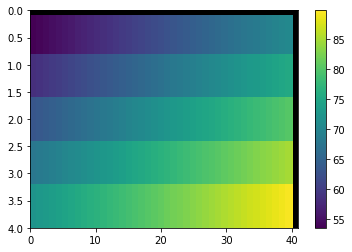

In [22]:
# Bus 1
i = 0
M_distance = M_distance_time(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
alignment = dtw(M_distance)
ax = plt.imshow(M_distance,aspect='auto',interpolation='none', extent=[0,max(alignment.index2),max(alignment.index1),0])
plt.colorbar()
plt.plot([alignment.index2[k] for k in range(0,len(alignment.index2))],[alignment.index1[k] for k in range(0,len(alignment.index1))],'black',linewidth=10)

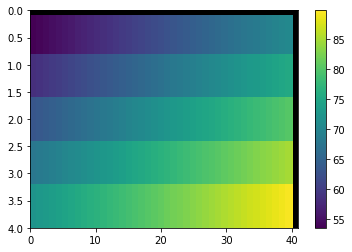

In [23]:
# Bus 1
i = 0
M_distance = M_distance_time(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
alignment = dtw(M_distance)
ax = plt.imshow(M_distance,aspect='auto',interpolation='none', extent=[0,max(alignment.index2),max(alignment.index1),0])
plt.colorbar()
plt.plot([alignment.index2[k] for k in range(0,len(alignment.index2))],[alignment.index1[k] for k in range(0,len(alignment.index1))],'black',linewidth=10)

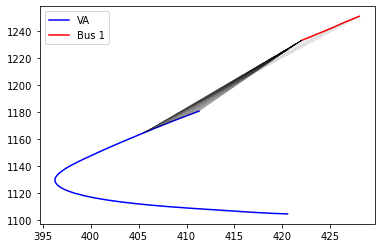

In [24]:
Chemin = [[alignment.index1[k],alignment.index2[k]] for k in range(0,len(alignment.index1))]

plt.plot(X_coord,Y_coord,'b',label='VA')
plt.plot([X_mobile[i][k] for k in range(0,len(X_mobile[i]))],[Y_mobile[i][k] for k in range(0,len(Y_mobile[i]))],'r',label = 'Bus '+str(i+1))
for k in range(0,len(Chemin)):
    trait_x_coord =[X_mobile[i][Chemin[k][0]],X_coord[Chemin[k][1]]]
    trait_y_coord =[Y_mobile[i][Chemin[k][0]],Y_coord[Chemin[k][1]]]
    plt.plot(trait_x_coord,trait_y_coord,'black',linestyle='--',linewidth=0.2)
plt.legend()

#### Travail sur les camions

In [25]:
# On travail sur les camions
catego_name = 'vehicle.truck'
catego_token = nusc.field2token('category','name',catego_name)
category = nusc.get('category',catego_token[0])
category

{'token': '6021b5187b924d64be64a702e5570edf',
 'name': 'vehicle.truck',
 'description': 'Vehicles primarily designed to haul cargo including pick-ups, lorrys, trucks and semi-tractors. Trailers hauled after a semi-tractor should be labeled as vehicle.trailer'}

In [26]:
# Ensemble des instances appartenant à la fois à la scène et à la catégorie
L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 

L=[]
for k in L_instance_category : 
    instance_category = nusc.get('instance',k)
    nbr_annotations = instance_category['nbr_annotations']
    if nbr_annotations == 1:
        L.append([instance_category['first_annotation_token']])
    else : 
        H = []
        first_token = instance_category['first_annotation_token']
        last_token = instance_category['last_annotation_token']
        current_token = first_token 
        
        i = 0 
        while i!= nbr_annotations :
            current_ann = nusc.get('sample_annotation', current_token)
            H.append(current_ann['token'])
            current_token = current_ann['next'] #On passe au suivant
            i+=1
        L.append(H)
# Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
# les token des sample_annotation pour un élément de cette catégorie. 

# Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
# on va pouvoir récupérer leurs positions 

X = []
Y = []
Z = []
T_time = []
for k in L :
    x = []
    y = []
    z = []
    t = []
    for j in k :
        sample_annotation = nusc.get('sample_annotation',j)
        x.append(sample_annotation['translation'][0])
        y.append(sample_annotation['translation'][1])
        z.append(sample_annotation['translation'][2])
        t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
    X.append(x)
    Y.append(y)
    Z.append(z)
    T_time.append(t)

Immo, Mobile = immobile(X,Y)

# On conserve uniquement les objets mobiles 
X_mobile=[X[i] for i in Mobile]
Y_mobile=[Y[i] for i in Mobile]
Z_mobile=[Z[i] for i in Mobile]
T_mobile = [T_time[i] for i in Mobile]
len(X_mobile)

1

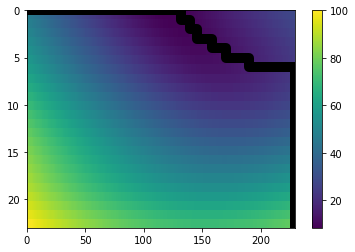

In [27]:
# Camion 1
i = 0
M_distance = M_distance_time(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
alignment = dtw(M_distance)
ax = plt.imshow(M_distance,aspect='auto',interpolation='none', extent=[0,max(alignment.index2),max(alignment.index1),0])
plt.colorbar()
plt.plot([alignment.index2[k] for k in range(0,len(alignment.index2))],[alignment.index1[k] for k in range(0,len(alignment.index1))],'black',linewidth=10)

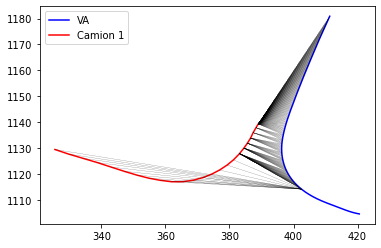

In [28]:
Chemin = [[alignment.index1[k],alignment.index2[k]] for k in range(0,len(alignment.index1))]

plt.plot(X_coord,Y_coord,'b',label='VA')
plt.plot([X_mobile[i][k] for k in range(0,len(X_mobile[i]))],[Y_mobile[i][k] for k in range(0,len(Y_mobile[i]))],'r',label = 'Camion '+str(i+1))
for k in range(0,len(Chemin)):
    trait_x_coord =[X_mobile[i][Chemin[k][0]],X_coord[Chemin[k][1]]]
    trait_y_coord =[Y_mobile[i][Chemin[k][0]],Y_coord[Chemin[k][1]]]
    plt.plot(trait_x_coord,trait_y_coord,'black',linestyle='--',linewidth=0.2)
plt.legend()